In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path= "../input/train/"

In [3]:
df = pd.read_csv('../input/train/train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
src = ImageList.from_csv(path, 'train.csv', folder='images').split_by_rand_pct(0.2, seed = 2)

In [5]:
tfms = get_transforms(max_rotate=20, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_df()
               .transform(tfms, size=size, padding_mode=padding_mode)
               .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

In [7]:
data = get_data(224, 16, 'zeros')

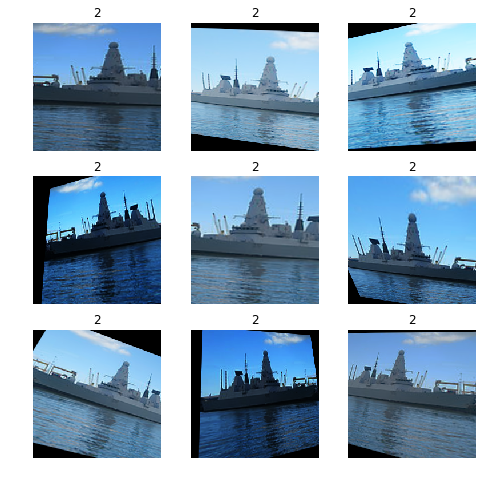

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 28697500.12it/s]


In [12]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.047834,0.655755,0.160800,01:32
1,0.625116,0.346424,0.120000,01:19
2,0.507969,0.291121,0.096000,01:21


In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07


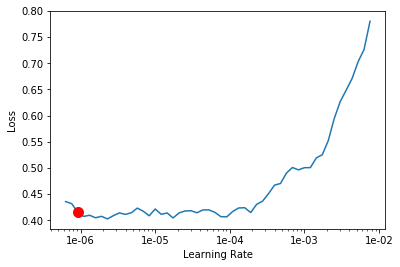

In [15]:
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(2, max_lr=slice(2e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.435257,0.286389,0.095200,01:25
1,0.398935,0.243756,0.072800,01:24


In [17]:
data = get_data(352,8)
learn.data = data

In [18]:
learn.fit_one_cycle(2, max_lr=slice(2e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.550763,0.247286,0.066400,03:03
1,0.466292,0.229875,0.057600,02:58


In [19]:
learn.save('/kaggle/working/352')

In [20]:
data = get_data(352,16)

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, model_dir='/tmp/models').load('/kaggle/working/352')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


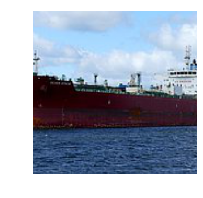

In [23]:
idx=0
x,y = data.valid_ds[idx]
x.show()
# data.valid_ds.y[idx]

In [24]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [25]:
k.shape

torch.Size([1, 3, 3, 3])

In [26]:
from fastai.callbacks.hooks import *

In [27]:
k.shape

torch.Size([1, 3, 3, 3])

In [28]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [29]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [30]:
edge = F.conv2d(t[None], k)

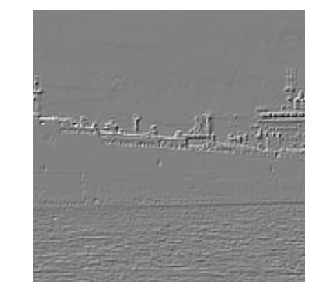

In [31]:
show_image(edge[0], figsize=(5,5));

In [33]:
m = learn.model.eval();

In [34]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [35]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [36]:
hook_a,hook_g = hooked_backward()

In [37]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [38]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [39]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


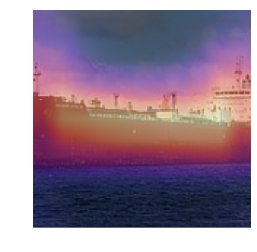

In [40]:
show_heatmap(avg_acts)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [11]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________